Reference evapotranspiration (ETₒ) is an essential variable in hydrology and agriculture for estimating the soil water balance. Reference evapotranspiration represents the evapotrasnpiration of a well-watered reference vegetation cover and is typically calculated using meteorological data. 

The Hargreaves model was developed to estimate ETₒ in regions where detailed meteorological data, such as solar radiation and wind speed, are not available. The Hargreaves model relies on easily obtainable variables like air temperature and extraterrestrial solar radiation ($R_a$) to provide a quick and practical estimation of ETₒ. The Hargreaves model is given by:

$$ ET_o = 0.0023 ~ R_a (T_{avg} + 17.8) ~ \sqrt{T_{max} - T_{min}} ~ 0.406$$

where $T_{avg}$ is mean air temperature during the period of consideration, $T_{min}$ is minimum air temperature, $T_{max}$ is maximum air temperature, and the factor 0.406 is the mm of water that can be evaporated per MJoule per $m^2$ based on a latent heat of vaporization of 2.465 MJ per kg of water.

In this tutorial we will try to come up with a machine learning model that approximates the ETₒ estimated with the Penman-Monteith model using the same input variables as in the Hargreaves model. The hypothesis is that the machine learning model will be able to learn intricate relatiosnhips between these two variables and result in better daily estimations of ETₒ compared to the Hargreaves model.



In [2]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

## Define functions to compute reference ET

In [3]:
# Add extraterrestrial radiation
# Source: Allen, R. G., Pereira, L. S., Raes, D., & Smith, M. (1998). 
# FAO Irrigation and drainage paper No. 56. 
# Rome: Food and Agriculture Organization of the United Nations, 56(97), e156.

def compute_Ra(doy, latitude):
    """Function that computes extraterrestrial solar radiation"""
    dr = 1 + 0.033 * np.cos(2 * np.pi * doy/365) # Inverse relative distance Earth-Sun
    phi = np.pi / 180 * latitude # Latitude in radians
    d = 0.409 * np.sin((2 * np.pi * doy/365) - 1.39) # Solar delcination
    omega = np.arccos(-np.tan(phi) * np.tan(d)) # Sunset hour angle
    Gsc = 0.0820 # Solar constant
    Ra = 24 * 60 / np.pi * Gsc * dr * (omega * np.sin(phi) * np.sin(d) + np.cos(phi) * np.cos(d) * np.sin(omega))
    return Ra

# Compute ETo using the Hargreaves model
def hargreaves(Ra,T_min,T_max):
    """Potential evapotranspiration model proposed by Hargreaves in 1982"""
    T_avg = (T_min + T_max)/2
    ETo = 0.0023 * Ra * (T_avg + 17.8) * (T_max - T_min)**0.5 * 0.4057
    return ETo


## Load, inspect, and merge datasets

In [4]:
# Read training dataset
df_1 = pd.read_csv('../datasets/Johnson_Kansas.csv', parse_dates=['timestamp'])
df_2 = pd.read_csv('../datasets/Greeley_Kansas.csv', parse_dates=['timestamp'])


In [5]:
# Inspect dataframe
df_1.head(3)


,id,longitude,latitude,timestamp,doy,pr,rmax,rmin,sph,srad,...,tmmn,tmmx,vs,erc,eto,bi,fm100,fm1000,etr,vpd
0,19800101,-94.822258,38.883761,1980-01-01,1,0.0,77.683876,43.286247,0.002620,8.263647,...,-3.557654,7.847253,2.192723,40.656410,1.040586,29.367460,13.726248,13.835570,1.627161,0.353715
1,19800102,-94.822258,38.883761,1980-01-02,2,0.0,78.571579,35.635567,0.002420,7.208553,...,-3.577643,5.967126,3.296802,41.918404,1.219669,35.399471,13.522950,13.820871,1.931061,0.320570
2,19800103,-94.822258,38.883761,1980-01-03,3,0.0,82.316978,39.000980,0.001985,5.930851,...,-7.448096,0.307275,3.042193,40.172096,0.770442,32.923172,13.797589,13.864967,1.172392,0.174911


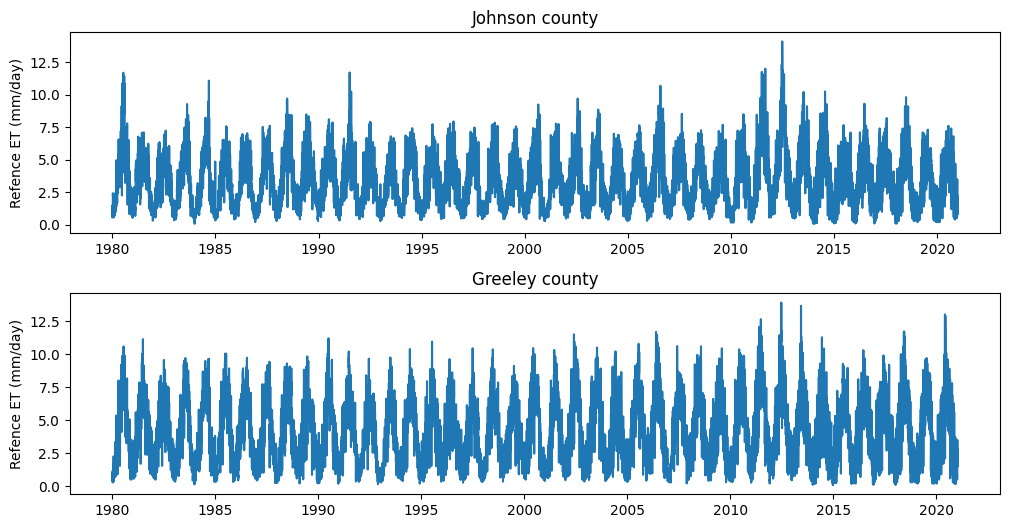

In [6]:
# Inspect data
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(df_1['timestamp'], df_1['eto'])
plt.title('Johnson county')
plt.ylabel('Refence ET (mm/day)')

plt.subplot(2,1,2)
plt.plot(df_2['timestamp'], df_2['eto'], label='Greeley county')
plt.title('Greeley county')
plt.ylabel('Refence ET (mm/day)')

plt.subplots_adjust(hspace=0.3)
plt.show()


In [21]:
# Merge dataframes
df = pd.concat([df_1, df_2]).reset_index(drop=True)


## Compute extraterrestrial solar radiation

In [22]:
# Add extraterrestrial solar radiation and ETo from Hargreaves model
df['Ra'] = compute_Ra(df['doy'], df['latitude'])
df['eto_harg'] = hargreaves(df['Ra'], df['tmmn'], df['tmmx'])


## Prepare input and output variables

In [23]:
# Prepare inputs and outputs
X = df[['Ra','tmmn','tmmx']].values
y = df['eto'].values


## Split and normalize data

In [24]:
# Split dataset
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, df.index.values, random_state=1)


In [25]:
# Normalize data
scaler = StandardScaler()  

# Scale training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  

# Apply same transformation to test data
X_test = scaler.transform(X_test) 


## Fit multilayer perceptron regressor


A multilayer perceptron regressor is a type of artificial neural network used for regression tasks, where the model learns to predict a continuous target variable. It consists of multiple layers of nodes (neurons), each connected to the nodes in the adjacent layers. The first layer is the input layer, the last layer is the output layer, and any layers in between are called hidden layers.

The Rectified Linear Unit (ReLU) activation function is commonly used in the hidden layers of a multilayer perceptron regressor. It replaces all negative values in the output with zero, while passing positive values unchanged (i.e., it retains the positive part of its argument only). This activation function helps the model learn complex patterns in the data and prevents the vanishing gradient problem typical of sigmoid and hyperbolic tangent activation functions, where gradients become too small for the model to learn effectively.

The Adam optimizer is a popular optimization algorithm used to update the weights of the neural network during training. It allows the MLP to use adaptive learning rates for each parameter, which rsults in faster convergence compared to the more traditional stochastic gradient descent.

In [26]:
# Create and fit multilayer perceptron (MLP)
MLP = MLPRegressor(random_state=1, max_iter=500, 
                   hidden_layer_sizes=(10), 
                   activation='relu', solver='adam')

# Fit MLP to training data
MLP_fitted = MLP.fit(X_train, y_train)

In [27]:
# Run trained MLP model on the test set
pred_test = MLP_fitted.predict(X_test)


In [28]:
# Compute the coefficient of determination
MLP_fitted.score(X_test, y_test)


0.9158784956141761

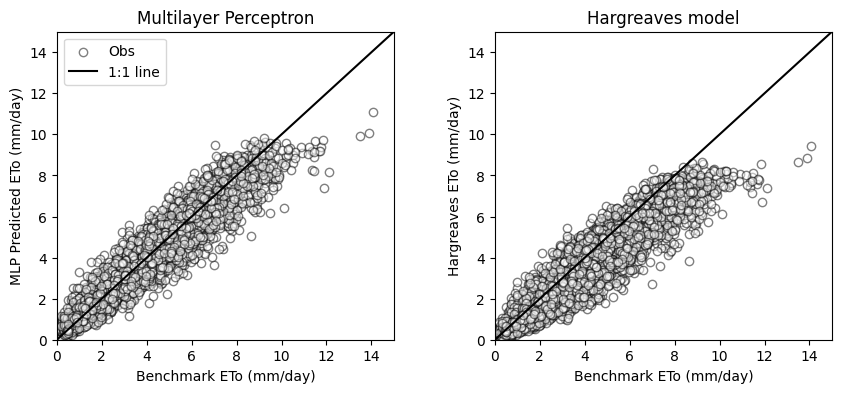

In [29]:
# Create scatter plots comparing test set and MLP predictions
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title('Multilayer Perceptron')
plt.scatter(y_test, pred_test, facecolor='w', edgecolor='k', alpha=0.5, label='Obs')
plt.plot([0,15],[0,15], '-k', label='1:1 line')
plt.xlim([0,15])
plt.ylim([0,15])
plt.xlabel('Benchmark ETo (mm/day)')
plt.ylabel('MLP Predicted ETo (mm/day)')
plt.legend()

plt.subplot(1,2,2)
plt.title('Hargreaves model')
plt.scatter(y_test, df['eto_harg'].iloc[idx_test],facecolor='w', edgecolor='k', alpha=0.5, )
plt.plot([0,15],[0,15], '-k')
plt.xlim([0,15])
plt.ylim([0,15])
plt.xlabel('Benchmark ETo (mm/day)')
plt.ylabel('Hargreaves ETo (mm/day)')

plt.subplots_adjust(wspace=0.3)
plt.show()


In [20]:
compute_mae = lambda x,y: round(np.nanmean(np.abs(x-y)),2)

mae_mlp = compute_mae(y_test, pred_test)
mae_hargreaves = compute_mae(y_test, df['eto_harg'].iloc[idx_test])

print('MAE MLP model:',mae_mlp, 'mm/day')
print('MAE Hargreaves model:', mae_hargreaves, 'mm/day')

MAE MLP model: 0.48 mm/day
MAE Hargreaves model: 0.91 mm/day


In this tutorial we learned that using a simple multilyaer perceptron regressor can be used to develop a reliable model of daily reference evapotrasnpiration using readily available data like latitude, day of the year, and air temperature. We also observed that this approach resulted more accurate than some simple and empirical models.

## Practice

- Download air temperature data from a station of the Kansas Mesonet to test the fitted MLP model. Download the corresponding ETo data computed by the KS Mesonet to validate the model predictions using an unseen dataset